**Considered problem:** In this notebook, we predict the DC power produced by an Indian solar energy plant 24 hours in advance to allow for better grid management.

**Purpose / research question:** This notebook has two goals. First, we would like to design a model with high prediction accuracy. Second, we would like to compare a state-of-the-art baseline from statistical time series analysis (SARIMAX) to some more sophisticated machine learning models. As discussed in the exercises, recurrent neural networks are particularly useful when dealing with sequence data, so we choose an LSTM net as our ML method. We have also seen in the lecture, that it is unclear whether more complex neural network models provide a benefit over the simple feed-forward architecture, so we shall include an MLP in our comparison to help closing this research gap.

The notebook is structured as follows:

<a id='top'></a>
[1. Data Inspection, Clean-Up & Preprocessing](#data) <br>
[2. Statistical Time Series Approaches](#tsa) <br>
&emsp; [2.1 Naive Baselines](#tsa_baselines) <br>
&emsp; [2.2 SARIMAX](#sarimax) <br>
[3. Neural Networks](#nn) <br>
&emsp; [3.1 MLP](#mlp) <br>
&emsp; [3.2 LSTM](#lstm) <br>
[4. Comparison](#comp) <br>
[5. Conclusion](#conclusion) <br>
&emsp; [5.1 Summary](#summary) <br>
&emsp; [5.2 Further Ideas](#ideas) <br>
&emsp; [5.3 Regarding this Notebook](#comments) <br>
[6. Excursion: Feature Importance](#f_imp) <br>
[7. Excursion: Ensemble Learning](#ensemble) <br>

In [1]:
# standard libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import datetime
from time import sleep
import scipy

# deep learning 
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from absl import logging as absl_logging
absl_logging.set_verbosity(absl_logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# scikit learn
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# tsa
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox

# XAI
import shap

# custom utility functions
from utils import PredictionResult, transf, inv_transf, eval_sarima, save_obj, load_obj, pipeline, eval_pipeline, eval_net
from utils import print_plot_results

# constants
from utils import N_TRAIN, N_DEV, N_TEST, M, BC

# turn off (irrelevant) warnings
import warnings
warnings.filterwarnings('ignore', message='Non-stationary starting')
warnings.filterwarnings('ignore', message='Maximum Likelihood optimization')
warnings.filterwarnings('ignore', message='Non-invertible starting')
warnings.filterwarnings('ignore', message='Too few observations')
warnings.filterwarnings('ignore', message='The test statistic')
warnings.filterwarnings(action='ignore', category=FutureWarning)

# 1. Data Inspection, Clean-Up & Preprocessing <a id='data'></a>
[to the top](#top)

First, we import the data sets (you can download it at: https://www.kaggle.com/anikannal/solar-power-generation-data). For simplicity, we will focus on plant 1 only.

In [2]:
gen_df = pd.read_csv('../Data Sets/Plant_1_Generation_Data.csv')
weather_df = pd.read_csv('../Data Sets/Plant_1_Weather_Sensor_Data.csv')

Let's print the first few rows to see what the data looks like.

In [3]:
gen_df.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0  15-05-2020 00:00   4135001  1BY6WEcLGh8j5v7       0.0       0.0   
1  15-05-2020 00:00   4135001  1IF53ai7Xc0U56Y       0.0       0.0   
2  15-05-2020 00:00   4135001  3PZuoBAID5Wc2HD       0.0       0.0   
3  15-05-2020 00:00   4135001  7JYdWkrLSPkdwr4       0.0       0.0   
4  15-05-2020 00:00   4135001  McdE0feGgRqW7Ca       0.0       0.0   

   DAILY_YIELD  TOTAL_YIELD  
0          0.0    6259559.0  
1          0.0    6183645.0  
2          0.0    6987759.0  
3          0.0    7602960.0  
4          0.0    7158964.0

In [4]:
weather_df.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0  2020-05-15 00:00:00   4135001  HmiyD2TTLFNqkNe            25.184316   
1  2020-05-15 00:15:00   4135001  HmiyD2TTLFNqkNe            25.084589   
2  2020-05-15 00:30:00   4135001  HmiyD2TTLFNqkNe            24.935753   
3  2020-05-15 00:45:00   4135001  HmiyD2TTLFNqkNe            24.846130   
4  2020-05-15 01:00:00   4135001  HmiyD2TTLFNqkNe            24.621525   

   MODULE_TEMPERATURE  IRRADIATION  
0           22.857507          0.0  
1           22.761668          0.0  
2           22.592306          0.0  
3           22.360852          0.0  
4           22.165423          0.0

Both sets provide one datapoint every 15 minutes for 34 days. 

gen_df:
- DATE_TIME: timestamp in format DD-MM-YYY hh:mm
- PLANT_ID: the ID of the plant, common across all rows
- SOURCE_KEY: the ID of the inverter, converting the produced direct current to alternating current
- DC_POWER: direct current power generated during the respective 15 minute interval in kW
- AC_POWER: alternating current power generated during the respective 15 minute interval in kW
- DAILY_YIELD: cumulative power generated by that inverter that day in kW
- TOTAL_YIELD: overall cumulative power generated by that inverter in kW

weather_df:
- DATE_TIME: timestamp in format YY-MM-DD h:mm:ss
- PLANT_ID: the ID of the plant, common across all rows
- SOURCE_KEY: the ID of sensor panel, common across all rows
- AMBIENT_TEMPERATURE: ambient temperature at the plant during that 15 minute interval in degree Celsius
- MODULE_TEMPERATURE: temperature of the solar panel the sensor panel is attachet to during that 15 minute interval in Celsius
- IRRADIATION: amount of solar irradiance during that 15 minute interval (probably in J/m^2)

<img src="../Images/SolarEnergyPlant.jpg">

<img src="../Images/SolarEnergyPlant2.jpg">

First, let's check if there are obvious irregularities in the data (e.g. temperature values of -9999.00 indicating missing values).

In [5]:
gen_df.describe().transpose().applymap("{:.2f}".format)

count        mean        std         min         25%  \
PLANT_ID     68778.00  4135001.00       0.00  4135001.00  4135001.00   
DC_POWER     68778.00     3147.43    4036.46        0.00        0.00   
AC_POWER     68778.00      307.80     394.40        0.00        0.00   
DAILY_YIELD  68778.00     3295.97    3145.18        0.00        0.00   
TOTAL_YIELD  68778.00  6978711.76  416271.98  6183645.00  6512002.54   

                    50%         75%         max  
PLANT_ID     4135001.00  4135001.00  4135001.00  
DC_POWER         429.00     6366.96    14471.12  
AC_POWER          41.49      623.62     1410.95  
DAILY_YIELD     2658.71     6274.00     9163.00  
TOTAL_YIELD  7146685.00  7268705.91  7846821.00

In [6]:
weather_df.describe().transpose().applymap("{:.2f}".format)

count        mean    std         min         25%  \
PLANT_ID             3182.00  4135001.00   0.00  4135001.00  4135001.00   
AMBIENT_TEMPERATURE  3182.00       25.53   3.35       20.40       22.71   
MODULE_TEMPERATURE   3182.00       31.09  12.26       18.14       21.09   
IRRADIATION          3182.00        0.23   0.30        0.00        0.00   

                            50%         75%         max  
PLANT_ID             4135001.00  4135001.00  4135001.00  
AMBIENT_TEMPERATURE       24.61       27.92       35.25  
MODULE_TEMPERATURE        24.62       41.31       65.55  
IRRADIATION                0.02        0.45        1.22

To work with dates, it is best to convert the provided strings to datetime instances.

In [7]:
gen_df['DATE_TIME'] = pd.to_datetime(gen_df['DATE_TIME'], format='%d-%m-%Y %H:%M')
weather_df['DATE_TIME'] = pd.to_datetime(weather_df['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

Let's have a quick look on one of the inverters during the first day.

In [8]:
show_rows = list(range(20, 30))
show_rows.extend(list(range(70, 80)))
gen_df[(gen_df['SOURCE_KEY']=='1BY6WEcLGh8j5v7') & (gen_df['DATE_TIME'].dt.date == datetime.date(2020, 5, 15))].iloc[show_rows, :]

DATE_TIME  PLANT_ID       SOURCE_KEY     DC_POWER    AC_POWER  \
425  2020-05-15 05:00:00   4135001  1BY6WEcLGh8j5v7     0.000000    0.000000   
447  2020-05-15 05:15:00   4135001  1BY6WEcLGh8j5v7     0.000000    0.000000   
468  2020-05-15 05:30:00   4135001  1BY6WEcLGh8j5v7     0.000000    0.000000   
489  2020-05-15 05:45:00   4135001  1BY6WEcLGh8j5v7     0.000000    0.000000   
510  2020-05-15 06:00:00   4135001  1BY6WEcLGh8j5v7    37.142857    3.585714   
531  2020-05-15 06:15:00   4135001  1BY6WEcLGh8j5v7   278.000000   26.862500   
552  2020-05-15 06:30:00   4135001  1BY6WEcLGh8j5v7   626.571429   60.685714   
574  2020-05-15 06:45:00   4135001  1BY6WEcLGh8j5v7  1224.750000  119.275000   
596  2020-05-15 07:00:00   4135001  1BY6WEcLGh8j5v7  1734.571429  170.014286   
618  2020-05-15 07:15:00   4135001  1BY6WEcLGh8j5v7  1856.375000  181.937500   
1520 2020-05-15 17:30:00   4135001  1BY6WEcLGh8j5v7  1091.000000  106.066667   
1542 2020-05-15 17:45:00   4135001  1BY6WEcLGh8j5v7   485.875000   47.012500   
1564 2020-05-15 18:00:00   4135001  1BY6WEcLGh8j5v7   264.000000   25.485714   
1586 2020-05-15 18:15:00   4135001  1BY6WEcLGh8j5v7    78.285714    7.542857   
1608 2020-05-15 18:30:00   4135001  1BY6WEcLGh8j5v7     0.000000    0.000000   
1630 2020-05-15 18:45:00   4135001  1BY6WEcLGh8j5v7     0.000000    0.000000   
1652 2020-05-15 19:00:00   4135001  1BY6WEcLGh8j5v7     0.000000    0.000000   
1666 2020-05-15 19:15:00   4135001  1BY6WEcLGh8j5v7     0.000000    0.000000   
1680 2020-05-15 19:30:00   4135001  1BY6WEcLGh8j5v7     0.000000    0.000000   
1694 2020-05-15 19:45:00   4135001  1BY6WEcLGh8j5v7     0.000000    0.000000   

      DAILY_YIELD  TOTAL_YIELD  
425      0.000000  6259559.000  
447      0.000000  6259559.000  
468      0.000000  6259559.000  
489      0.000000  6259559.000  
510      0.000000  6259559.000  
531      2.625000  6259561.625  
552     13.285714  6259572.286  
574     34.875000  6259593.875  
596     72.714286  6259631.714  
618    116.250000  6259675.250  
1520  5719.000000  6265278.000  
1542  5739.750000  6265298.750  
1564  5749.285714  6265308.286  
1586  5753.142857  6265312.143  
1608  5754.000000  6265313.000  
1630  5754.000000  6265313.000  
1652  5754.000000  6265313.000  
1666  5754.000000  6265313.000  
1680  5754.000000  6265313.000  
1694  5754.000000  6265313.000

As could be expected, there is no power generated at night-time. It seems like approximately 90% of the generated power is lost when converting from DC to AC. Again, some power seems to be lost from AC to the actual yield, and the yield lags behind by one timestep. <br>
In general, we may use this data set to answer the following questions (cf. https://www.kaggle.com/anikannal/solar-power-generation-data?select=Plant_1_Weather_Sensor_Data.csv):

1. Can we predict the power generation for next couple of days? This allows for better grid management.
2. Can we identify the need for panel cleaning/maintenance?
3. Can we identify faulty or suboptimally performing equipment, especially inverters? 

All questions are highly relevant for energy production. For the scope of our course, we are most interested in the prediction of power generation, so we shall address question 1. To avoid noise introduced by faulty equipment like the inverters, we will predict the DC power generated (instead of the daily yield), and we shall aggregate it over all inverters. Before we aggregate the data, let us look at possible missing values.

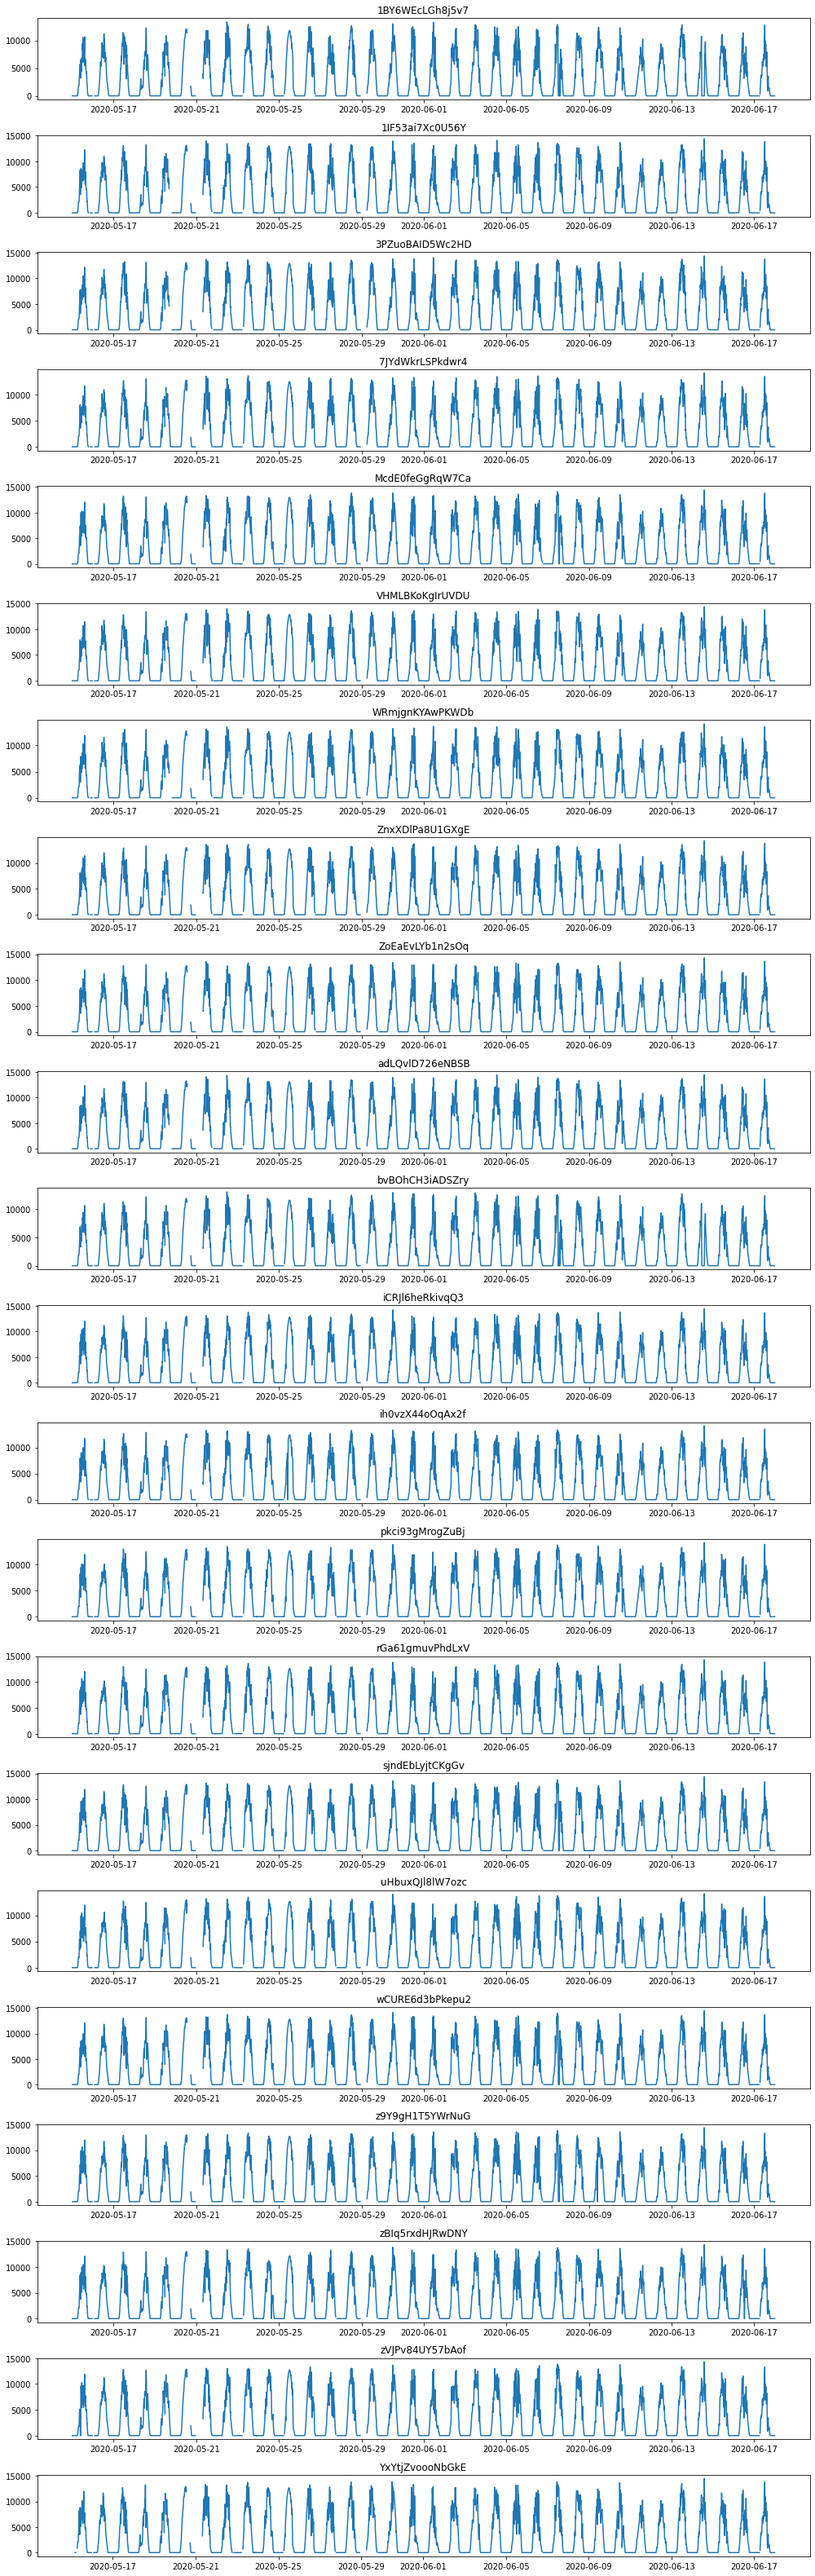

In [9]:
n_plots = len(gen_df['SOURCE_KEY'].unique())
ncols = 1
nrows = int(np.ceil(n_plots/ncols))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*14, nrows*2), squeeze=False)

start = datetime.datetime(2020, 5, 15, 0, 0, 0)
end = datetime.datetime(2020, 6, 17, 23, 45, 0)
date_df = pd.DataFrame({'time': pd.date_range(start, end, freq='15min')})

for n_plot, inverter in enumerate(gen_df['SOURCE_KEY'].unique()):
    inverter_df = gen_df[gen_df['SOURCE_KEY']==inverter]
    inverter_df = pd.merge(left=date_df, right=inverter_df, how='left', left_on='time', right_on='DATE_TIME')
    
    ax[n_plot//ncols, n_plot%ncols].plot(inverter_df['time'], inverter_df['DC_POWER'])
    ax[n_plot//ncols, n_plot%ncols].set_title(inverter)
fig.tight_layout()

Clearly, there are times at which no data seems to have been recorded (especially around the 20th/21st of May). Let's check those dates more thoroughly.

In [10]:
inverter_df[inverter_df['time'].dt.date==datetime.date(2020, 5, 20)].iloc[40:]

time           DATE_TIME   PLANT_ID       SOURCE_KEY  \
520 2020-05-20 10:00:00 2020-05-20 10:00:00  4135001.0  YxYtjZvoooNbGkE   
521 2020-05-20 10:15:00 2020-05-20 10:15:00  4135001.0  YxYtjZvoooNbGkE   
522 2020-05-20 10:30:00 2020-05-20 10:30:00  4135001.0  YxYtjZvoooNbGkE   
523 2020-05-20 10:45:00 2020-05-20 10:45:00  4135001.0  YxYtjZvoooNbGkE   
524 2020-05-20 11:00:00 2020-05-20 11:00:00  4135001.0  YxYtjZvoooNbGkE   
525 2020-05-20 11:15:00 2020-05-20 11:15:00  4135001.0  YxYtjZvoooNbGkE   
526 2020-05-20 11:30:00 2020-05-20 11:30:00  4135001.0  YxYtjZvoooNbGkE   
527 2020-05-20 11:45:00 2020-05-20 11:45:00  4135001.0  YxYtjZvoooNbGkE   
528 2020-05-20 12:00:00 2020-05-20 12:00:00  4135001.0  YxYtjZvoooNbGkE   
529 2020-05-20 12:15:00 2020-05-20 12:15:00  4135001.0  YxYtjZvoooNbGkE   
530 2020-05-20 12:30:00 2020-05-20 12:30:00  4135001.0  YxYtjZvoooNbGkE   
531 2020-05-20 12:45:00 2020-05-20 12:45:00  4135001.0  YxYtjZvoooNbGkE   
532 2020-05-20 13:00:00 2020-05-20 13:00:00  4135001.0  YxYtjZvoooNbGkE   
533 2020-05-20 13:15:00 2020-05-20 13:15:00  4135001.0  YxYtjZvoooNbGkE   
534 2020-05-20 13:30:00                 NaT        NaN              NaN   
535 2020-05-20 13:45:00                 NaT        NaN              NaN   
536 2020-05-20 14:00:00                 NaT        NaN              NaN   
537 2020-05-20 14:15:00                 NaT        NaN              NaN   
538 2020-05-20 14:30:00                 NaT        NaN              NaN   
539 2020-05-20 14:45:00                 NaT        NaN              NaN   
540 2020-05-20 15:00:00                 NaT        NaN              NaN   
541 2020-05-20 15:15:00                 NaT        NaN              NaN   
542 2020-05-20 15:30:00                 NaT        NaN              NaN   
543 2020-05-20 15:45:00                 NaT        NaN              NaN   
544 2020-05-20 16:00:00                 NaT        NaN              NaN   
545 2020-05-20 16:15:00                 NaT        NaN              NaN   
546 2020-05-20 16:30:00                 NaT        NaN              NaN   
547 2020-05-20 16:45:00                 NaT        NaN              NaN   
548 2020-05-20 17:00:00                 NaT        NaN              NaN   
549 2020-05-20 17:15:00                 NaT        NaN              NaN   
550 2020-05-20 17:30:00 2020-05-20 17:30:00  4135001.0  YxYtjZvoooNbGkE   
551 2020-05-20 17:45:00 2020-05-20 17:45:00  4135001.0  YxYtjZvoooNbGkE   
552 2020-05-20 18:00:00 2020-05-20 18:00:00  4135001.0  YxYtjZvoooNbGkE   
553 2020-05-20 18:15:00 2020-05-20 18:15:00  4135001.0  YxYtjZvoooNbGkE   
554 2020-05-20 18:30:00 2020-05-20 18:30:00  4135001.0  YxYtjZvoooNbGkE   
555 2020-05-20 18:45:00 2020-05-20 18:45:00  4135001.0  YxYtjZvoooNbGkE   
556 2020-05-20 19:00:00 2020-05-20 19:00:00  4135001.0  YxYtjZvoooNbGkE   
557 2020-05-20 19:15:00 2020-05-20 19:15:00  4135001.0  YxYtjZvoooNbGkE   
558 2020-05-20 19:30:00 2020-05-20 19:30:00  4135001.0  YxYtjZvoooNbGkE   
559 2020-05-20 19:45:00 2020-05-20 19:45:00  4135001.0  YxYtjZvoooNbGkE   
560 2020-05-20 20:00:00 2020-05-20 20:00:00  4135001.0  YxYtjZvoooNbGkE   
561 2020-05-20 20:15:00 2020-05-20 20:15:00  4135001.0  YxYtjZvoooNbGkE   
562 2020-05-20 20:30:00 2020-05-20 20:30:00  4135001.0  YxYtjZvoooNbGkE   
563 2020-05-20 20:45:00 2020-05-20 20:45:00  4135001.0  YxYtjZvoooNbGkE   
564 2020-05-20 21:00:00 2020-05-20 21:00:00  4135001.0  YxYtjZvoooNbGkE   
565 2020-05-20 21:15:00 2020-05-20 21:15:00  4135001.0  YxYtjZvoooNbGkE   
566 2020-05-20 21:30:00 2020-05-20 21:30:00  4135001.0  YxYtjZvoooNbGkE   
567 2020-05-20 21:45:00 2020-05-20 21:45:00  4135001.0  YxYtjZvoooNbGkE   
568 2020-05-20 22:00:00 2020-05-20 22:00:00  4135001.0  YxYtjZvoooNbGkE   
569 2020-05-20 22:15:00 2020-05-20 22:15:00  4135001.0  YxYtjZvoooNbGkE   
570 2020-05-20 22:30:00 2020-05-20 22:30:00  4135001.0  YxYtjZvoooNbGkE   
571 2020-05-20 22:45:00 2020-05-20 22:45:00  4135001.0  YxYtjZvoooNbGkE   
572 2020-05-20 23:00:00                 NaT 

There are a couple things to notice:
1. Usually, when there is data missing, it is missing for all inverters. This suggests that we could interpolate the missing values after aggregating them. We will stil be careful and fill the NaNs individually by inverter.
2. The way in which the data is missing suggests that linear interpolating the missing values is a reasonable approach, although it is far from perfect. Especially for missing values at the beginning / end of the day, one could do better by inserting zeros where appropriate.

In [11]:
# compute the earliest sunrise and latest sunset in the data

earliest_start = datetime.time(23, 45, 0)
latest_end = datetime.time(0, 0, 0)
for date in tqdm(gen_df['DATE_TIME'].dt.date.unique()):
    for inverter in gen_df['SOURCE_KEY'].unique():
        extract = gen_df[(gen_df['DATE_TIME'].dt.date==date) & (gen_df['SOURCE_KEY']==inverter)]
        start_day = extract[extract['DC_POWER']>0]['DATE_TIME'].iloc[0].time()
        end_day = extract[extract['DC_POWER']>0]['DATE_TIME'].iloc[-1].time()
        earliest_start = min(earliest_start, start_day)
        latest_end = max(latest_end, end_day)
print('Earliest sunrise: {}. Latest sunset: {}'.format(earliest_start, latest_end))

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:18<00:00,  1.84it/s]

Earliest sunrise: 06:00:00. Latest sunset: 18:30:00


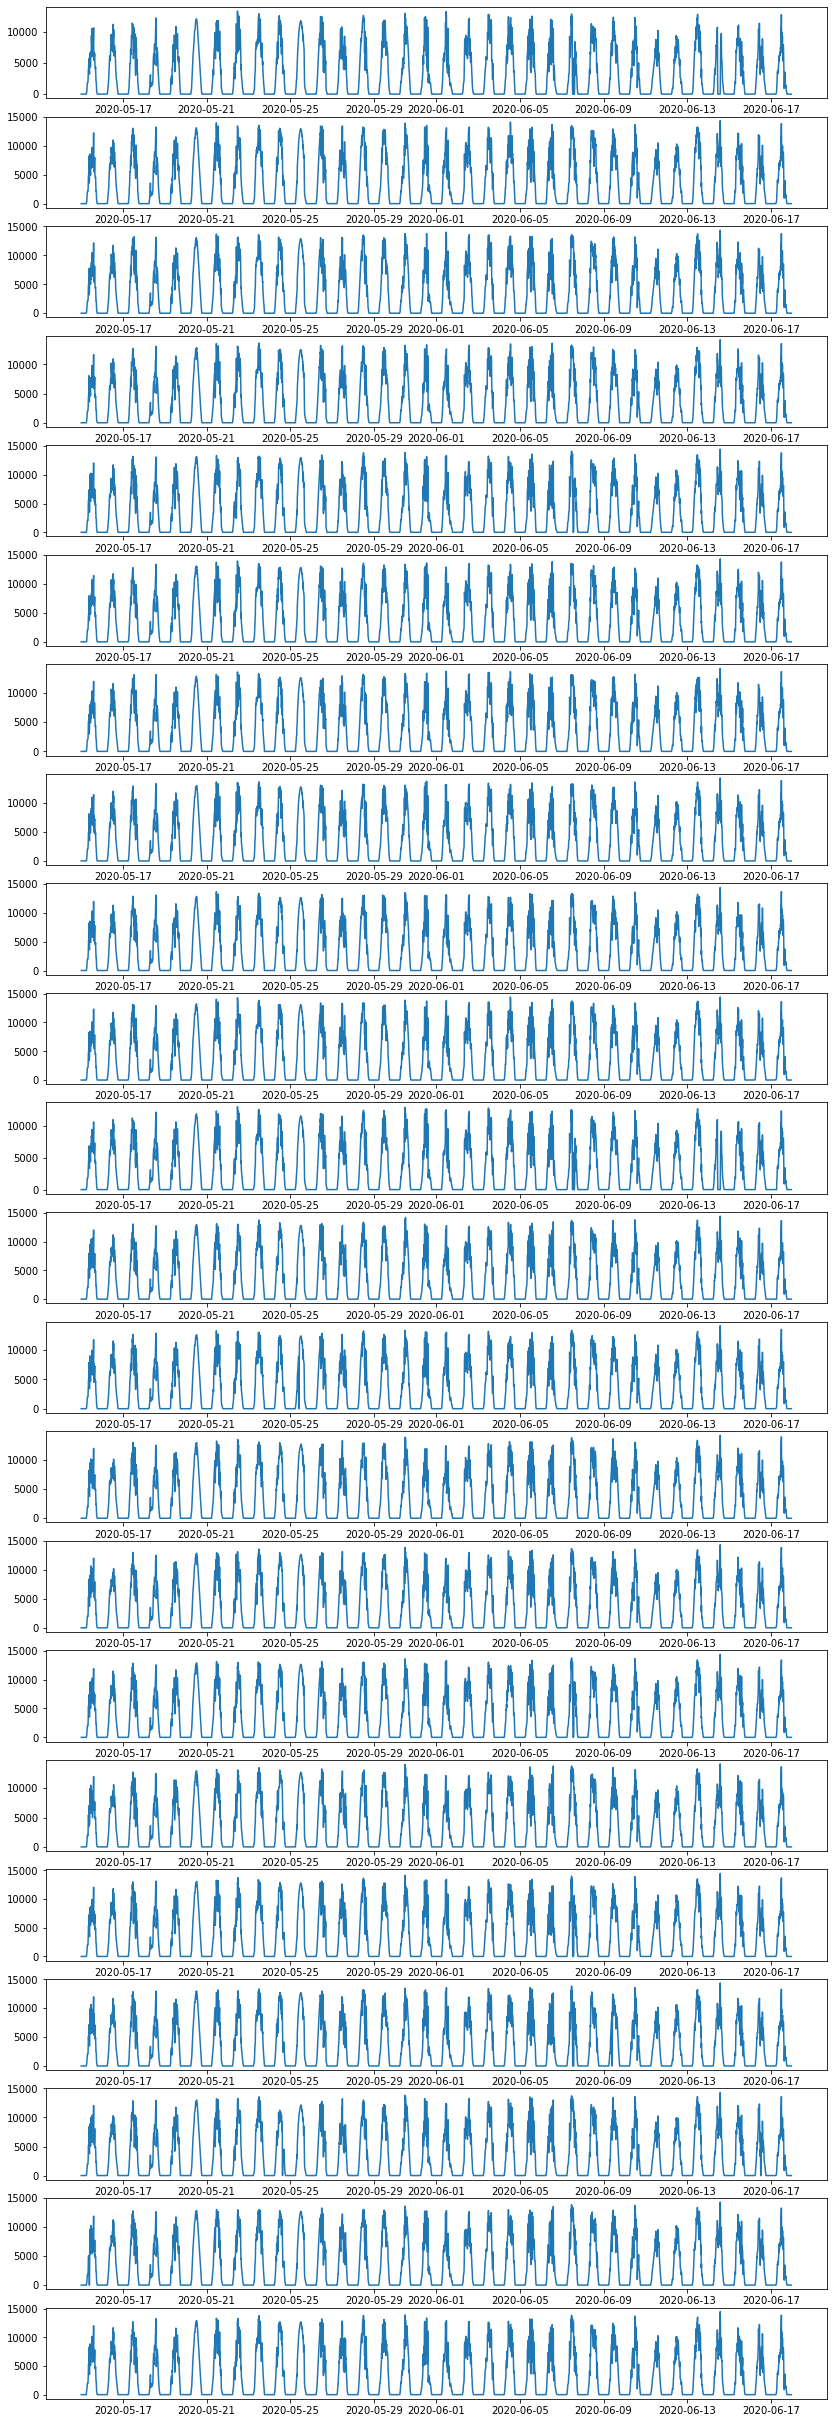

In [12]:
# for each day and each inverter, fill NaNs before 6:00 and after 18:30 with zeros, then interpolate linearly 
# also, rename the columns
# resulting df is called clean_gen_df

n_plots = len(gen_df['SOURCE_KEY'].unique())
ncols = 1
nrows = int(np.ceil(n_plots/ncols))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*14, nrows*2), squeeze=False)

start = datetime.datetime(2020, 5, 15, 0, 0, 0)
end = datetime.datetime(2020, 6, 17, 23, 45, 0)
date_df = pd.DataFrame({'time': pd.date_range(start, end, freq='15min')})
clean_gen_df = pd.DataFrame()

for n_plot, inverter in enumerate(gen_df['SOURCE_KEY'].unique()):
    inverter_df = gen_df[gen_df['SOURCE_KEY']==inverter].copy()
    inverter_df = pd.merge(left=date_df, right=inverter_df, how='left', left_on='time', right_on='DATE_TIME')
    inverter_df = inverter_df[['time', 'SOURCE_KEY', 'DC_POWER']].rename(mapper={'SOURCE_KEY': 'inverter', 'DC_POWER': 'dc'},
                                                                         axis=1)
    inverter_df['inverter'] = inverter
    zero_idx = inverter_df[(inverter_df['time'].dt.time < earliest_start ) | (inverter_df['time'].dt.time > latest_end) ].index
    inverter_df.loc[zero_idx, 'dc'] = inverter_df.loc[zero_idx, 'dc'].fillna(0)
    inverter_df['dc'] = inverter_df['dc'].interpolate(method='linear')
    clean_gen_df = clean_gen_df.append(inverter_df)
    
    ax[n_plot//ncols, n_plot%ncols].plot(inverter_df['time'], inverter_df['dc'])

In [13]:
clean_gen_df

time         inverter   dc
0    2020-05-15 00:00:00  1BY6WEcLGh8j5v7  0.0
1    2020-05-15 00:15:00  1BY6WEcLGh8j5v7  0.0
2    2020-05-15 00:30:00  1BY6WEcLGh8j5v7  0.0
3    2020-05-15 00:45:00  1BY6WEcLGh8j5v7  0.0
4    2020-05-15 01:00:00  1BY6WEcLGh8j5v7  0.0
...                  ...              ...  ...
3259 2020-06-17 22:45:00  YxYtjZvoooNbGkE  0.0
3260 2020-06-17 23:00:00  YxYtjZvoooNbGkE  0.0
3261 2020-06-17 23:15:00  YxYtjZvoooNbGkE  0.0
3262 2020-06-17 23:30:00  YxYtjZvoooNbGkE  0.0
3263 2020-06-17 23:45:00  YxYtjZvoooNbGkE  0.0

[71808 rows x 3 columns]

We may now aggregate the data across inverters.

In [14]:
agg_df = clean_gen_df[['time', 'dc']].groupby('time').sum().reset_index()
agg_df.iloc[20:30]

time            dc
20 2020-05-15 05:00:00      0.000000
21 2020-05-15 05:15:00      0.000000
22 2020-05-15 05:30:00      0.000000
23 2020-05-15 05:45:00      0.000000
24 2020-05-15 06:00:00   1233.148810
25 2020-05-15 06:15:00   6724.101190
26 2020-05-15 06:30:00  15271.154762
27 2020-05-15 06:45:00  28626.589287
28 2020-05-15 07:00:00  41345.914287
29 2020-05-15 07:15:00  44564.208330

Before we go on to fit our models, let's clean up and merge the weather data set and create some additional features of our own.

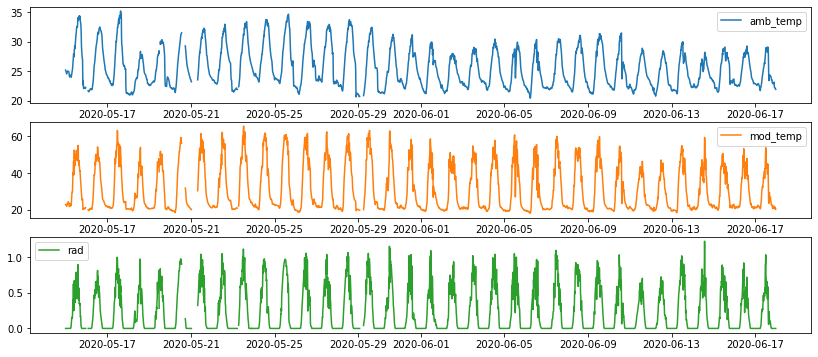

In [15]:
start = datetime.datetime(2020, 5, 15, 0, 0, 0)
end = datetime.datetime(2020, 6, 17, 23, 45, 0)
date_df = pd.DataFrame({'time': pd.date_range(start, end, freq='15min')})

ext_weather_df = pd.merge(left=date_df, right=weather_df, how='left', left_on='time', right_on='DATE_TIME')
ext_weather_df = ext_weather_df[['time', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']].rename(
                    mapper={'AMBIENT_TEMPERATURE':'amb_temp', 'MODULE_TEMPERATURE':'mod_temp',
                            'IRRADIATION':'rad'}, axis=1)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 6))
for row, col in enumerate(['amb_temp', 'mod_temp', 'rad']):
    ax[row].plot(ext_weather_df['time'], ext_weather_df[col], label=col, color='C'+str(row))
    ax[row].legend()

What do we notice?
- Unsurprisingly, the solar irradiance seems to be perfectly correlated with the generated DC power.
- Especially for the module temperature and the irradiance, the missing values occur with the same pattern as the missing values for the DC power.
- Again, one might be able to do better than simply linearly interpolating the values, but it seems to be a safe choice. Since the irradiance should be 0 at nighttime, we insert zeros as before.

In [16]:
clean_weather_df = ext_weather_df.copy()

clean_weather_df['amb_temp'] = clean_weather_df['amb_temp'].interpolate(method='linear')
clean_weather_df['mod_temp'] = clean_weather_df['mod_temp'].interpolate(method='linear')

zero_idx = clean_weather_df[(clean_weather_df['time'].dt.time<earliest_start) | (clean_weather_df['time'].dt.time>latest_end) ].index
clean_weather_df.loc[zero_idx, 'rad'] = clean_weather_df.loc[zero_idx, 'rad'].fillna(0)
clean_weather_df['rad'] = clean_weather_df['rad'].interpolate(method='linear')

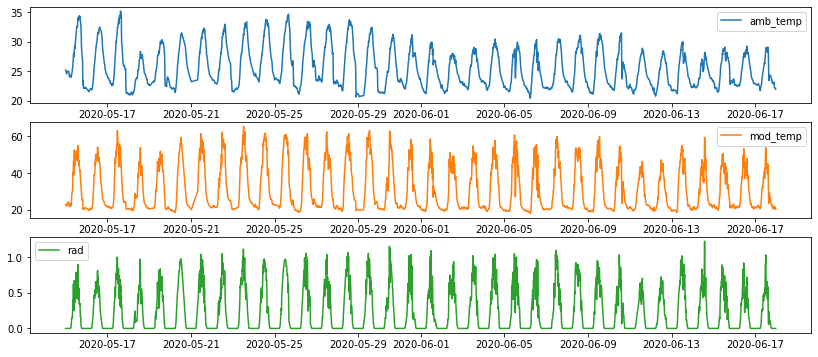

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 6))
for row, col in enumerate(['amb_temp', 'mod_temp', 'rad']):
    ax[row].plot(clean_weather_df['time'], clean_weather_df[col], label=col, color='C'+str(row))
    ax[row].legend()

In [18]:
agg_df = pd.merge(left=agg_df, right=clean_weather_df, on='time')
agg_df.head()

time   dc   amb_temp   mod_temp  rad
0 2020-05-15 00:00:00  0.0  25.184316  22.857507  0.0
1 2020-05-15 00:15:00  0.0  25.084589  22.761668  0.0
2 2020-05-15 00:30:00  0.0  24.935753  22.592306  0.0
3 2020-05-15 00:45:00  0.0  24.846130  22.360852  0.0
4 2020-05-15 01:00:00  0.0  24.621525  22.165423  0.0

As mentioned, for our feature-aware models, we would like to create 2 simple features of our own. This shall allow them to have an explicit access to the passing of time, which should simplify their work in detecting the obvious daily seasonality.

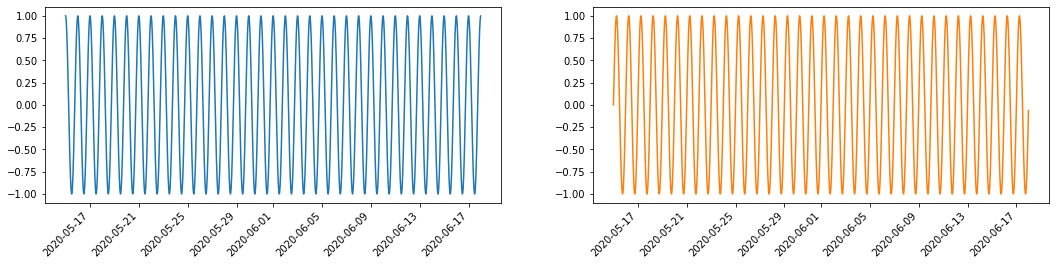

In [19]:
agg_df['time_cos_24'] = np.cos(2*np.pi*np.arange(len(agg_df))/96)
agg_df['time_sin_24'] = np.sin(2*np.pi*np.arange(len(agg_df))/96)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
ax[0].plot(agg_df['time'], agg_df['time_cos_24'], color='C0')
ax[1].plot(agg_df['time'], agg_df['time_sin_24'], color='C1')
fig.autofmt_xdate(rotation=45)

The period of the seasonality might not always be obvious. A handy way to detect seasonalities is via the discrete fourier transformation of the series:

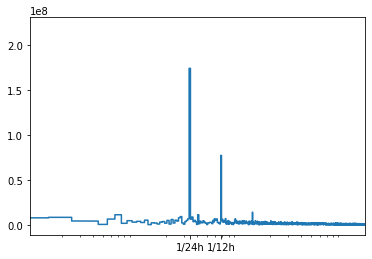

In [20]:
fft = abs(tf.signal.rfft(agg_df['dc']))
sfft = np.array(sorted(fft, reverse=True))
frequencies = np.arange(0, len(fft))

plt.step(frequencies, fft, where='mid')
plt.xlim(1, len(fft))
plt.xscale('log')

_ = plt.xticks([34, 68], labels=['1/24h', '1/12h'])

Here, the Fourier transform confirms the daily seasonality, but has also a second considerable spike that suggests some repeating behaviour every 12 hours. We may want to include that as well.

In [21]:
agg_df['time_cos_12'] = np.cos(2*np.pi*np.arange(len(agg_df))/48)
agg_df['time_sin_12'] = np.sin(2*np.pi*np.arange(len(agg_df))/48)

In [22]:
# remove the time column and save the preprocessed data

energy_time = agg_df.pop('time')
energy_time.to_csv(r'../Data Sets/energy_time_raw.csv', index=False)
agg_df.to_csv(r'../Data Sets/agg_df_raw.csv', index=False)

As a final step, let's take a look at the correlation matrix.

<AxesSubplot:>

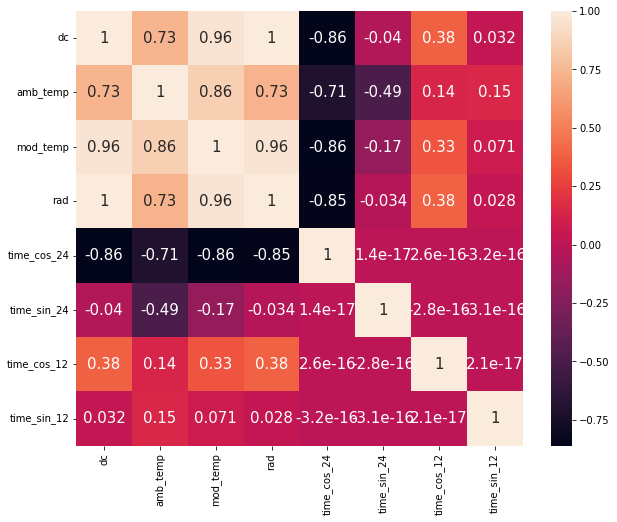

In [23]:
# agg_df = pd.read_csv(r'../Data Sets/agg_df_raw.csv')
corr = agg_df.corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, annot_kws={'fontsize': 15}, ax=ax)

As expected, module temperature and irradiance are almost perfectly correlated with our target. For a standard regression task, this would be ideal, as it would render the prediction problem trivial. However, keep in mind that we want to predict solar power generation 1 day (or multiple days) in advance, and we do not have access to next day's module temperature or solar irradiance. (At least for irradiance, in a real-case scenario, we might get our hands on predictions, but in the given data set, they are not included and very hard to recreate, as we do not even know where exactly the solar power plant is located). We might therefore:
- discard mod_temp and rad altogether as we can simply use past dc values as a feature instead,
- add past dc as a feature and
- analyze 24 hrs - ahead correlation instead.

In [24]:
agg_df['dc_24'] = np.concatenate(([np.nan]*M, agg_df['dc'].values[:-M]))
agg_df['amb_temp_24'] = np.concatenate(([np.nan]*M, agg_df['amb_temp'].values[:-M]))

agg_df = agg_df.drop(['mod_temp', 'rad', 'amb_temp'], axis=1)
agg_df = agg_df[M:]
energy_time = energy_time[M:]

agg_df.to_csv(r'../Data Sets/agg_df.csv', index=False)
energy_time.to_csv(r'../Data Sets/energy_time.csv', index=False)

agg_df

dc  time_cos_24   time_sin_24  time_cos_12   time_sin_12  dc_24  \
96    0.0     1.000000 -2.449294e-16     1.000000 -4.898587e-16    0.0   
97    0.0     0.997859  6.540313e-02     0.991445  1.305262e-01    0.0   
98    0.0     0.991445  1.305262e-01     0.965926  2.588190e-01    0.0   
99    0.0     0.980785  1.950903e-01     0.923880  3.826834e-01    0.0   
100   0.0     0.965926  2.588190e-01     0.866025  5.000000e-01    0.0   
...   ...          ...           ...          ...           ...    ...   
3259  0.0     0.946930 -3.214395e-01     0.793353 -6.087614e-01    0.0   
3260  0.0     0.965926 -2.588190e-01     0.866025 -5.000000e-01    0.0   
3261  0.0     0.980785 -1.950903e-01     0.923880 -3.826834e-01    0.0   
3262  0.0     0.991445 -1.305262e-01     0.965926 -2.588190e-01    0.0   
3263  0.0     0.997859 -6.540313e-02     0.991445 -1.305262e-01    0.0   

      amb_temp_24  
96      25.184316  
97      25.084589  
98      24.935753  
99      24.846130  
100     24.621525  
...           ...  
3259    22.872359  
3260    22.962205  
3261    22.947974  
3262    22.925033  
3263    22.892004  

[3168 rows x 7 columns]

<AxesSubplot:>

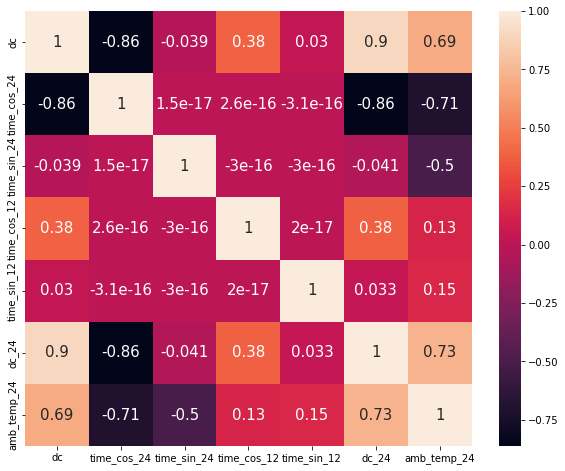

In [25]:
corr = agg_df.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, annot_kws={'fontsize': 15}, ax=ax)

To make sure that no information from the development and test sets spill over into the training data, let's define what portion of the data is used for training, development and testing. We apply a split of 70/20/10.

In [26]:
days_total = len(agg_df) // 96
n_train = int(np.round(days_total*.7))*96
n_dev = int(np.round(days_total*.2))*96
n_test = len(agg_df)-n_train-n_dev

print(n_train, n_train/96, n_dev, n_dev/96, n_test, n_test/96)

2208 23.0 672 7.0 288 3.0


As we will need training, development and test set sizes multiple times throughout the notebook, I defined them as constants in the utils.py-file. <br>
We will now separate the different data subsets physically. However, the different methods we use require different preprocessing and data formatting routines, so we have to resort to the complete dataframe "agg_df" from time to time - we should take special care to use the same development and test sets for all methods to ensure our results are comparable. Also note that we do NOT shuffle the data (as you might be used to for other ML applications), so as to ensure the models are trained to predict the future and to preserve the data's temporal interdependencies.

<img src="../Images/TSA_TrainDevTestSplit.png">

In [27]:
from utils import N_TRAIN, N_DEV, N_TEST

train_df = agg_df[:N_TRAIN].copy()
dev_df = agg_df[N_TRAIN:N_TRAIN+N_DEV].copy()
test_df = agg_df[N_TRAIN+N_DEV:].copy()

train_df.to_csv(r'../Data Sets/train_df.csv', index=False)
dev_df.to_csv(r'../Data Sets/dev_df.csv', index=False)
test_df.to_csv(r'../Data Sets/test_df.csv', index=False)

Also remember how our models are fit and used for prediction: for time series data, we use a rolling horizon approach.

<img src="../Images/TSA_RollingHorizon.png">

# 2. Statistical Time Series Methods <a id='tsa'></a>
[to the top](#top)

# 2.1 Naive Time Series Methods <a id='tsa_baselines'></a>
[to the top](#top)

Let us first design some baselines. The naive baseline, which simply predicts the value observed one timestep earlier, is not applicable, as we would like to predict 24 hours into the future. However, it seems very reasonable to look at the naive method's seasonal counterpart (predicting the value observed 1 day ago) and the seasonal moving average (which takes the average over the last k values of the same season: i.e., for k=3, we would average the values observed 24, 48 and 72 hours ago).

**Seasonal naive:**

In [28]:
agg_df = pd.read_csv(r'../Data Sets/agg_df.csv')

y_dev = agg_df['dc'].values[N_TRAIN:N_TRAIN+N_DEV]
preds_dev = agg_df['dc'].values[N_TRAIN-M:N_TRAIN+N_DEV-M]

y_test = agg_df['dc'].values[N_TRAIN+N_DEV:]
preds_test = agg_df['dc'].values[N_TRAIN+N_DEV-M:-M]

result_snaive = PredictionResult('snaive', y_dev, preds_dev, y_test, preds_test)
result_snaive.compute_errors()

# save results
combined_results = load_obj(r'../Results', r'/combined_prediction_results')
combined_results['snaive'] = result_snaive
sleep(1)
save_obj(combined_results, r'../Results', r'/combined_prediction_results')

In [29]:
# errors on dev set
print('Dev Set Errors:', result_snaive.errors[:3])

Dev Set Errors: [36376.322611222655, 35.28019588864537, -782.6630526192997]


**Seasonal moving average:**

Dev Set Errors: [27311.666475880775, 30.78149535350446, -1819.3268493117253]


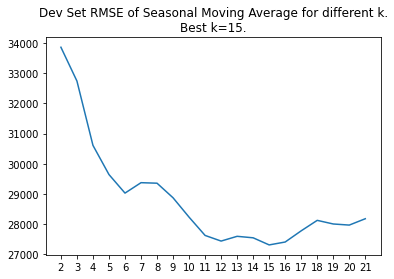

In [30]:
# determine the optimal number k of past seasons over which to take the average

agg_df = pd.read_csv(r'../Data Sets/agg_df.csv')
y_dev = agg_df['dc'].values[N_TRAIN:N_TRAIN+N_DEV]
y_test = agg_df['dc'].values[N_TRAIN+N_DEV:]


# iterate through k's
min_rmse = np.inf
max_k = 21 # maximum lookback of 3 weeks, or use N_TRAIN // 96
k_ls, rmse_ls = range(2, max_k+1), []
for k in k_ls:
    preds_dev_k = np.array([np.mean(agg_df['dc'].values[t-k*M:t:M]) for t in range(N_TRAIN, N_TRAIN+N_DEV)])
    rmse = np.sqrt( np.mean( (y_dev-preds_dev_k)**2 ) )
    rmse_ls.append(rmse)
    if rmse < min_rmse:
        min_rmse = rmse
        best_k = k
        preds_dev = preds_dev_k

# plot errors vs. k
plt.plot(k_ls, rmse_ls)
plt.xticks(k_ls)
plt.title('Dev Set RMSE of Seasonal Moving Average for different k.\nBest k={}.'.format(best_k))

# compute test set predictions with best k
preds_test = np.array([np.mean(agg_df['dc'].values[t-best_k*M:t:M]) for t in range(N_TRAIN+N_DEV, N_TRAIN+N_DEV+N_TEST)])

# create result object
result_sma = PredictionResult('sma', y_dev, preds_dev, y_test, preds_test)
result_sma.compute_errors()
print('Dev Set Errors:', result_sma.errors[:3])

# save results
combined_results = load_obj(r'../Results', r'/combined_prediction_results')
combined_results['sma'] = result_sma
sleep(1)
save_obj(combined_results, r'../Results', r'/combined_prediction_results')

**Visualize baselines:**

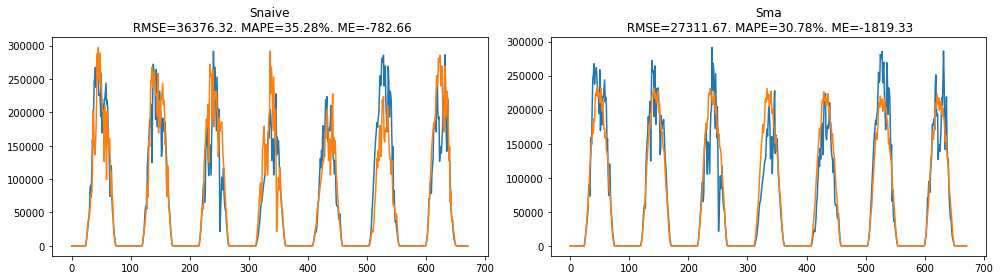

In [31]:
nrows, ncols = 1, 2
fig, ax = plt.subplots(nrows, ncols, figsize=(14, 4), squeeze=False)

for n_plot, method in enumerate(['snaive', 'sma']):
    res = combined_results[method]
    ax[n_plot//ncols, n_plot%ncols].plot(res.y_dev, label='target')
    ax[n_plot//ncols, n_plot%ncols].plot(res.preds_dev, label='predictions')
    ax[n_plot//ncols, n_plot%ncols].set_title('{}\n RMSE={:.2f}. MAPE={:.2f}%. ME={:.2f}'
                                              .format(method.capitalize(), res.rmse_dev, res.mape_dev, res.me_dev))
    
fig.tight_layout()

By design, the seasonal naive method produces very fuzzy, unstable predictions. The seasonal moving average produces much smoother and more reliable forecasts.

# 2.2 SARIMAX <a id='sarimax'></a>
[to the top](#top)

Now that we have an idea of what performance level we want to beat, let's design an ARIMA model.

**1. Check stationarity.**

In [32]:
# boxcox transformation

agg_df = pd.read_csv('../Data Sets/agg_df.csv')
y_train_transf, lam, ci = boxcox(agg_df['dc'].values[:N_TRAIN]+BC, alpha=.1)
lam, ci

(0.011363340798736632, (0.001353520588550765, 0.02136286690906274))

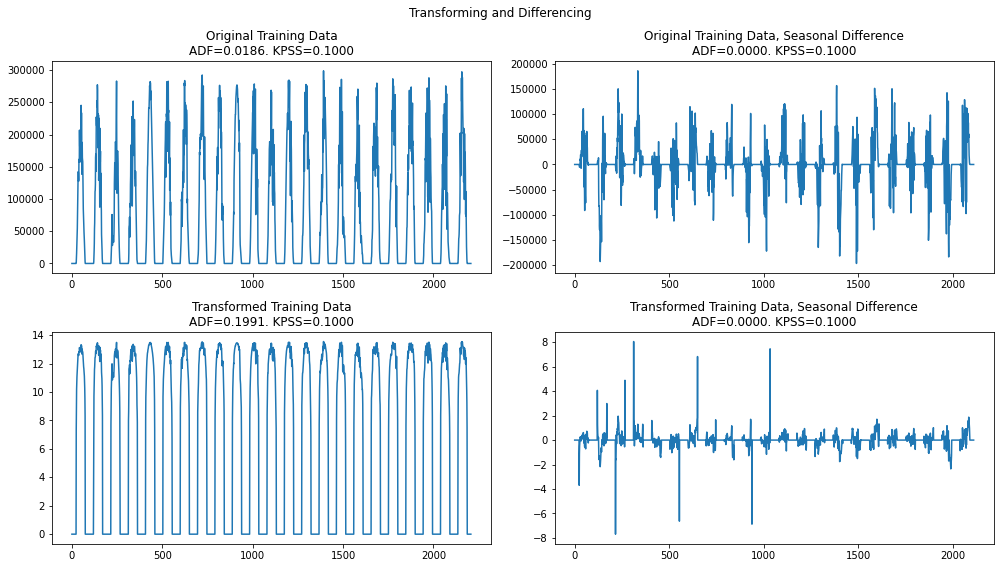

In [33]:
# plot original, transformed and seasonally differenced series

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

for row, y in enumerate([agg_df['dc'].values[:N_TRAIN], y_train_transf]):
    
    row_title = 'Original Training Data' if row==0 else 'Transformed Training Data'
    
    for col, plot_y in enumerate([y, y[96:]-y[:-96]]):      
        
        p_adf = adfuller(plot_y, maxlag=96)[1]
        p_kpss = kpss(plot_y, nlags='auto')[1]
        
        ax[row, col].plot(plot_y)
        col_title = row_title + ', Seasonal Difference' if col == 1 else row_title 
        col_title += '\nADF={:.4f}. KPSS={:.4f}'.format(p_adf, p_kpss)
        ax[row, col].set_title(col_title)
        
fig.suptitle('Transforming and Differencing')
fig.tight_layout()

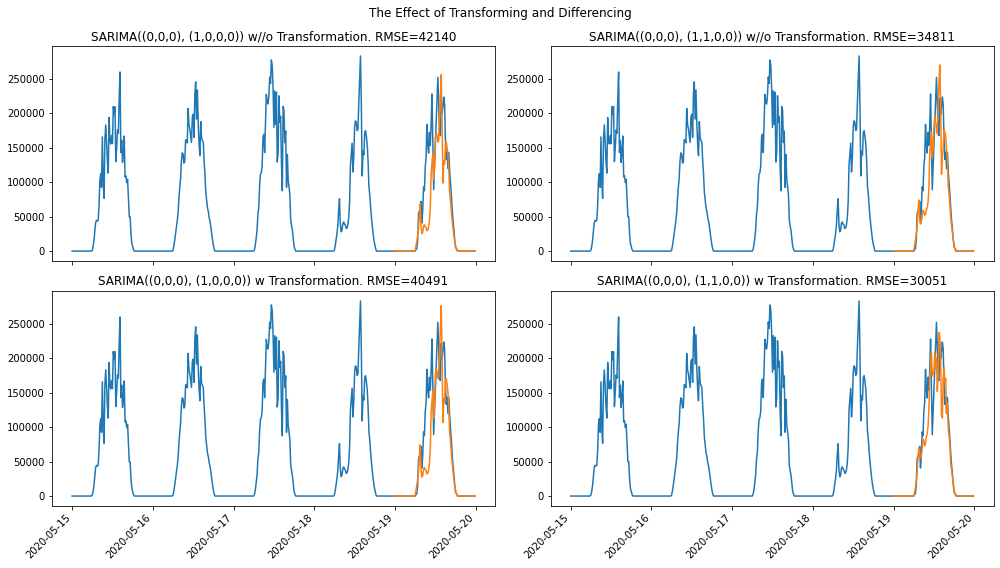

In [34]:
# a quick check if differencing and transforming is beneficial:
# fit a SARIMA((0,0,0),(1,d,0,0)) with d={0,1} on a fraction of the data (to save time) and check errors

agg_df = pd.read_csv(r'../Data Sets/agg_df_raw.csv')
energy_time = pd.to_datetime(pd.read_csv(r'../Data Sets/energy_time_raw.csv')['time'].values)

start_train = 0
end_train = 4*M
eval_len = M
y_train = agg_df['dc'].values[start_train:end_train]
y_eval = agg_df['dc'].values[end_train:end_train+eval_len]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

for row, transform in enumerate([False, True]):
    y_train_mod = transf(y_train) if transform else y_train
    for col, d in enumerate([0, 1]):
        model = ARIMA(y_train_mod, order=(0,0,0), seasonal_order=(1, d, 0, M), trend='n')
        model = model.fit()
        preds = model.predict(start=end_train, end=end_train+eval_len-1)
        preds = inv_transf(preds) if transform else preds
        rmse = np.sqrt( np.mean( (y_eval-preds)**2 ) )
        ax = axes[row,col]
        ax.plot(energy_time[start_train:end_train+eval_len], agg_df['dc'].values[start_train:end_train+eval_len],
                label='actuals')
        ax.plot(energy_time[end_train:end_train+eval_len], preds, label='predictions')
        ax.set_title('SARIMA((0,0,0), (1,{},0,0)) {} Transformation. RMSE={:.0f}'.format(d, 'w' if transform else 'w//o', rmse))
    
fig.autofmt_xdate(rotation=45)
fig.suptitle('The Effect of Transforming and Differencing')
fig.tight_layout()

Conclusion:
- Both the ADF and the KPSS test are already satisfied with the original time series, although it obviously is not (definitely both the mean and the variance change over time, there is an obvious seasonality). The reason for that is that those tests are designed to detect unit roots (the most common and "dangerous" source for non-stationarity), and it is very unlikely that there is one in the present data. We will transform and difference the data anyway, as that comes closer to the stationary series the ARIMA model is expecting and has obvious benefits.
- For this type of time series, there are even more appropriate models than ARIMA, e.g. ETS and GARCH models. Those approaches are better in capturing variance shifts and obvious seasonalities. We will cover ETS in the Supply Chain Management exercise classes, for GARCH see e.g. https://arch.readthedocs.io/en/latest/univariate/introduction.html#.

**2. Initial Guess**

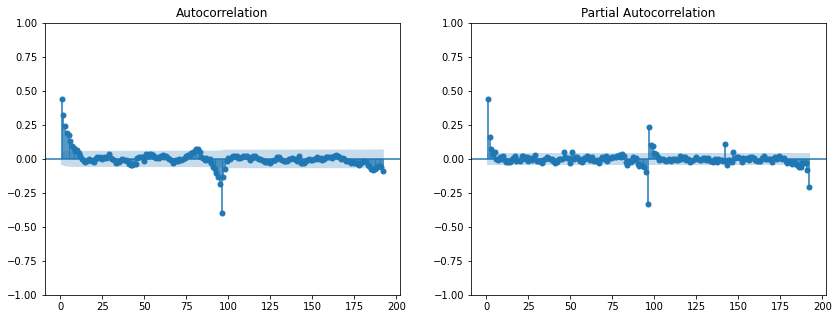

In [35]:
agg_df = pd.read_csv(r'../Data Sets/agg_df.csv')
y_transf = transf(agg_df['dc'].values[:N_TRAIN])
y_diff = y_transf[96:] - y_transf[:-96]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
_ = plot_acf(y_diff, lags=range(1,193), ax=ax[0])
_ = plot_pacf(y_diff, lags=range(1,193), ax=ax[1])

Initial Guess(es):
- SARIMA( (0,0,1), (0,1,1,96) )
- SARIMA( (1,0,0), (0,1,1,96) )
- SARIMA( (1,0,1), (0,1,1,96) )

In [36]:
orders_sarima = [((0,0,1), (0,1,1,96)), ((1,0,0), (0,1,1,96)), ((1,0,1), (0,1,1,96))]
results_sarima_initguess = {}

for order, seasonal_order in orders_sarima:
    
    start = datetime.datetime.now()
    
    print('Starting cross-validated evaluation of SARIMA(({},{},{}), ({},{},{},{})).'.format(*order, *seasonal_order))
    
    results_sarima_initguess[(order, seasonal_order)] = eval_sarima(order, seasonal_order)
    
    elapsed = (datetime.datetime.now()-start).total_seconds()
    
    print('\nFinished SARIMA(({},{},{}), ({},{},{},{})). Elapsed (in seconds): {:.2f}. RMSE={:.4f}.\n'
          .format(*order, *seasonal_order, elapsed, results_sarima_initguess[(order, seasonal_order)][0]))
    
save_obj(results_sarima_initguess, r'../Results', r'/sarima_initial_guesses')

Starting cross-validated evaluation of SARIMA((0,0,1), (0,1,1,96)).
Completed CV Splits (of 4): 1,2,3,4,
Finished SARIMA((0,0,1), (0,1,1,96)). Elapsed (in seconds): 66.24. RMSE=34331.1005.

Starting cross-validated evaluation of SARIMA((1,0,0), (0,1,1,96)).
Completed CV Splits (of 4): 1,2,3,4,
Finished SARIMA((1,0,0), (0,1,1,96)). Elapsed (in seconds): 60.99. RMSE=34362.6469.

Starting cross-validated evaluation of SARIMA((1,0,1), (0,1,1,96)).
Completed CV Splits (of 4): 1,2,3,4,
Finished SARIMA((1,0,1), (0,1,1,96)). Elapsed (in seconds): 91.10. RMSE=34016.9981.



In [37]:
min(results_sarima_initguess, key=lambda order: results_sarima_initguess[order][0])

((1, 0, 1), (0, 1, 1, 96))

**4. Improve upon best initial guess.**

In [38]:
max_q = 4
orders_sarima = [((1,0,q), (1,1,1,96)) for q in range(2, max_q+1)] # ...
results_sarima_improved = {}

for order, seasonal_order in orders_sarima:
    
    start = datetime.datetime.now()
    
    print('Starting cross-validated evaluation of SARIMA(({},{},{}), ({},{},{},{})).'.format(*order, *seasonal_order))
    
    results_sarima_improved[(order, seasonal_order)] = eval_sarima(order, seasonal_order)
    
    elapsed = (datetime.datetime.now()-start).total_seconds()
    
    print('\nFinished SARIMA(({},{},{}), ({},{},{},{})). Elapsed (in seconds): {:.2f}. RMSE={:.4f}.\n'
          .format(*order, *seasonal_order, elapsed, results_sarima_improved[(order, seasonal_order)][0]))
    
save_obj(results_sarima_improved, r'../Results', r'/sarima_improved_guesses')

Starting cross-validated evaluation of SARIMA((1,0,2), (1,1,1,96)).
Completed CV Splits (of 4): 1,2,3,4,
Finished SARIMA((1,0,2), (1,1,1,96)). Elapsed (in seconds): 196.57. RMSE=34438.0979.

Starting cross-validated evaluation of SARIMA((1,0,3), (1,1,1,96)).
Completed CV Splits (of 4): 1,2,3,4,
Finished SARIMA((1,0,3), (1,1,1,96)). Elapsed (in seconds): 338.99. RMSE=34155.6376.

Starting cross-validated evaluation of SARIMA((1,0,4), (1,1,1,96)).
Completed CV Splits (of 4): 1,2,3,4,
Finished SARIMA((1,0,4), (1,1,1,96)). Elapsed (in seconds): 307.70. RMSE=34257.1038.



In [39]:
# results_sarima_improved = load_obj(r'../Results', r'/sarima_improved_guesses')
min(results_sarima_improved, key=lambda order: results_sarima_improved[order][0])

((1, 0, 3), (1, 1, 1, 96))

**5. Determine best model, make dev set and test set predctions and save result.**

In [40]:
sarima_initguesses = load_obj(r'../Results', r'/sarima_initial_guesses')
sarima_improved = load_obj(r'../Results', r'/sarima_improved_guesses')
sarima_models = {**sarima_initguesses, **sarima_improved}

min(sarima_models, key=lambda order: sarima_models[order][0])

((1, 0, 1), (0, 1, 1, 96))

Remember that this parameter combination was among our initial guesses (!)

In [41]:
order, seasonal_order = (1,0,1), (0,1,1,96)

_, preds_dev = eval_sarima(order, seasonal_order, mode='search', n_cvs=7)
print()
_, preds_test = eval_sarima(order, seasonal_order, mode='test', n_cvs=3)


agg_df = pd.read_csv(r'../Data Sets/agg_df.csv')
y_dev = agg_df['dc'].values[N_TRAIN:N_TRAIN+N_DEV]
y_test = agg_df['dc'].values[N_TRAIN+N_DEV:]

res_sarima = PredictionResult('sarima', y_dev, preds_dev, y_test, preds_test)
res_sarima.compute_errors()

combined_results = load_obj('../Results', r'/combined_prediction_results')
combined_results['sarima'] = res_sarima
sleep(1)
save_obj(combined_results, '../Results', r'/combined_prediction_results')

Completed CV Splits (of 7): 1,2,3,4,5,6,7,
Completed CV Splits (of 3): 1,2,3,

**Visualize dev set predictions**

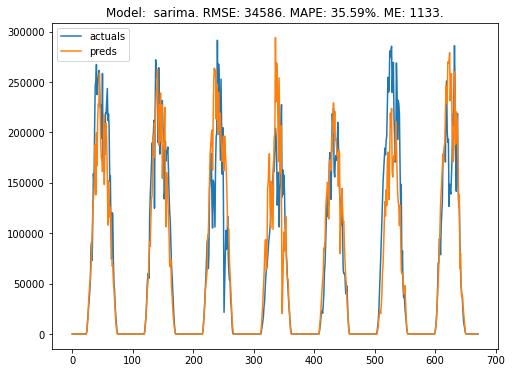

In [42]:
res_sarima = load_obj('../Results', r'/combined_prediction_results')['sarima']

fig, ax = plt.subplots(figsize=(8, 6))
print_plot_results(res_sarima, ax=ax, mode='dev')

**SARIMAX**

Let's see if we can improve our model by adding exogenous variables. As mentioned last week, we should standardize them so as to simplify the coefficient estimation. Technically, we should also adapt the model order - thanks to the periodic covariates we provided ourselves, some of the seasonal coefficients might be redundant now. For the sake of time, we leave the model order as is.

In [43]:
agg_df = pd.read_csv(r'../Data Sets/agg_df.csv')
y_dev = agg_df['dc'].values[N_TRAIN:N_TRAIN+N_DEV]
y_test = agg_df['dc'].values[N_TRAIN+N_DEV:]

scaler_arima = StandardScaler()
scaler_arima = scaler_arima.fit(agg_df.iloc[:N_TRAIN, 1:])
exog = scaler_arima.transform(agg_df.iloc[:, 1:])

order, seasonal_order = (1,0,1), (0,1,0,96) # (1,0,1), (1,1,1,96)
_, preds_dev = eval_sarima(order, seasonal_order, mode='search', n_train=3*96, n_cvs=7, exog=exog)
print()
_, preds_test = eval_sarima(order, seasonal_order, mode='test', n_train=3*96, n_cvs=3, exog=exog)

res_sarimax = PredictionResult('sarimax', y_dev, preds_dev, y_test, preds_test)
res_sarimax.compute_errors()

combined_results = load_obj('../Results', r'/combined_prediction_results')
combined_results['sarimax'] = res_sarimax
sleep(1)
save_obj(combined_results, '../Results', r'/combined_prediction_results')

Completed CV Splits (of 7): 1,2,3,4,5,6,7,
Completed CV Splits (of 3): 1,2,3,

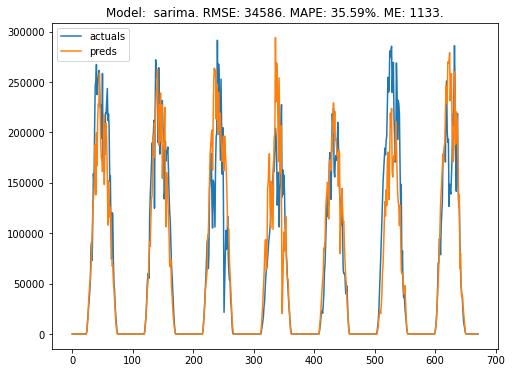

In [44]:
res_sarimax = load_obj('../Results', r'/combined_prediction_results')['sarimax']

fig, ax = plt.subplots(figsize=(8, 6))
print_plot_results(res_sarima, ax=ax, mode='dev')

# 3. Neural Networks <a id='nn'></a>
[to the top](#top)

In this section, we fit two neural network architectures and see if we can improve upon the statistical time series methods. We start with a simple feed-forward network and then move on to an LSTM net.

## 3.1 MLP <a id='mlp'></a>
[to the top](#top)

In [45]:
# prepare data

agg_df = pd.read_csv(r'../Data Sets/agg_df.csv')
MLP_scaler = StandardScaler()
MLP_scaler.fit(agg_df.iloc[:N_TRAIN, :])
MLP_data = MLP_scaler.transform(agg_df)
MLP_X, MLP_y = MLP_data[:, 1:], MLP_data[:, 0]

In [46]:
# hyperparameters
# play around to see if you can improve the model by choosing better hyperparams

lr = .001
hidden_nodes = [64, 64]
max_epochs = 100
patience = 10
batch_size = 32

hp = lr, hidden_nodes, max_epochs, patience, batch_size

In [47]:
# evaluation

rmse, y_target, preds, _ = eval_net(*hp, model_type='MLP', X=MLP_X, y=MLP_y, verbose=True, man_adjust=True,
                                        keras_verbose=False, scaler=MLP_scaler, n_cvs=7)

print("RMSE: {:.0f}".format(rmse))

Completed CV Splits (of 7): 1,2,3,4,5,6,7,RMSE: 28964


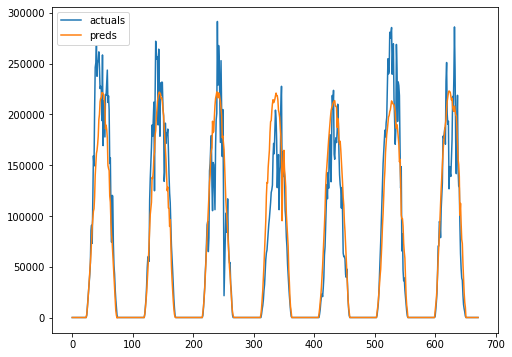

In [48]:
# visualize results

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(y_target, label='actuals')
ax.plot(preds, label='preds')
ax.legend()

In [49]:
# after you're happy with your hyperparamaters, make predictions on development and test set

_, y_dev, preds_dev, mlp = eval_net(*hp, model_type='MLP', X=MLP_X, y=MLP_y, verbose=True, man_adjust=True, keras_verbose=False,
                                scaler=MLP_scaler, mode='search', n_cvs=7)
mlp.save(r'C:/Users/rbeier/Desktop/AIinIndustry23/Energy_Models/mlp')
print()
_, y_test, preds_test, _ = eval_net(*hp, model_type='MLP', X=MLP_X, y=MLP_y, verbose=True, man_adjust=True, keras_verbose=False,
                                scaler=MLP_scaler, mode='test', n_cvs=3)

res_mlp = PredictionResult('mlp', y_dev, preds_dev, y_test, preds_test)
res_mlp.compute_errors()

Completed CV Splits (of 7): 1,2,3,4,5,6,7,
Completed CV Splits (of 3): 1,2,3,

In [50]:
# save results
combined_results = load_obj(r'../Results', r'/combined_prediction_results')
combined_results['mlp'] = res_mlp
sleep(1)
save_obj(combined_results, r'../Results', r'/combined_prediction_results')

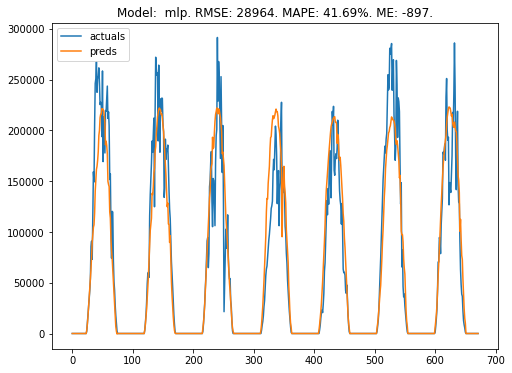

In [51]:
# visualize results

fig, ax = plt.subplots(figsize=(8, 6))
print_plot_results(res_mlp, ax=ax, mode='dev')

As we have hoped, the neural network produces rather smooth, stable predictions and does not pick up on the random noise.

## 3.2 LSTM <a id='lstm'></a>
[to the top](#top)

In [52]:
# prepare data
# remember the difference between agg_df_raw and agg_df: for the latter, we discarded the first day
# as we have to reformat the data now anyway, we import the original data

agg_df = pd.read_csv(r'../Data Sets/agg_df_raw.csv').drop(['rad', 'mod_temp'], axis=1)
orig_y = agg_df['dc'].values

lstm_scaler = StandardScaler()
lstm_scaler.fit(agg_df.iloc[:N_TRAIN+96, :])
LSTM_X_raw = lstm_scaler.transform(agg_df)
LSTM_y = LSTM_X_raw[:, 0] 

<img src="../Images/LSTM_Keras.png" width="700" height="800">

Source: https://github.com/MohammadFneish7/Keras_LSTM_Diagram, retrieved 10.03.2022

In [53]:
# prepare data format

timesteps = 4*12 # "width" of unfolded architecture, i.e. number of vectors in a sequence
offset = 96 # we predict the dc power 96 timesteps ahead

LSTM_X = []
for t in range(len(LSTM_X_raw)-offset-timesteps+1):
    LSTM_X.append(LSTM_X_raw[t:t+timesteps, :])
LSTM_X = np.stack(LSTM_X)

LSTM_y = LSTM_y[timesteps+offset-1:]
orig_y = orig_y[timesteps+offset-1:]

Dimensions of our data: (number of instances, timesteps, number of features)

In [54]:
print(LSTM_X.shape, LSTM_y.shape)

(3121, 48, 6) (3121,)


In [55]:
lr = .01
hidden_nodes = [16, 16]
max_epochs = 30
patience = 10
batch_size = 128

hp = lr, hidden_nodes, max_epochs, patience, batch_size

Completed CV Splits (of 3): 1,2,3,RMSE: 26306


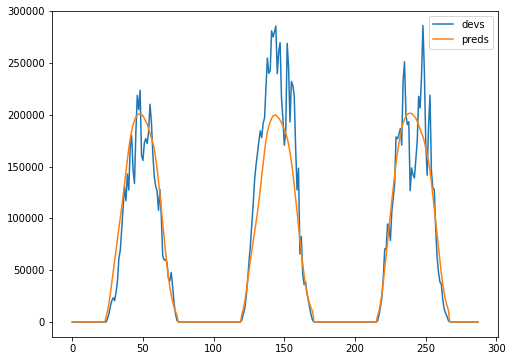

In [56]:
# evaluation

rmse, y_target, preds, _ = eval_net(*hp, model_type='LSTM', X=LSTM_X, y=LSTM_y, timesteps=timesteps, verbose=True,
                                       man_adjust=True, scaler=lstm_scaler, mode='search', n_cvs=3)

print('RMSE: {:.0f}'.format(rmse))

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(y_target, label='devs')
ax.plot(preds, label='preds')
ax.legend()

In [57]:
# after you're happy with your hyperparameters, make predictions on development and test set

_, y_dev, preds_dev, lstm = eval_net(*hp, model_type='LSTM', X=LSTM_X, y=LSTM_y, verbose=True, man_adjust=True, keras_verbose=False,
                                scaler=lstm_scaler, mode='search', n_cvs=7)
lstm.save(r'C:/Users/rbeier/Desktop/AIinIndustry23/Energy_Models/lstm')
print()
_, y_test, preds_test, _ = eval_net(*hp, model_type='LSTM', X=LSTM_X, y=LSTM_y, verbose=True, man_adjust=True, keras_verbose=False,
                                scaler=lstm_scaler, mode='test', n_cvs=3)

res_lstm = PredictionResult('lstm', y_dev, preds_dev, y_test, preds_test)
res_lstm.compute_errors()

Completed CV Splits (of 7): 1,2,3,4,5,6,7,
Completed CV Splits (of 3): 1,2,3,

In [58]:
# save results
combined_results = load_obj(r'../Results', r'/combined_prediction_results')
combined_results['lstm'] = res_lstm
sleep(1)
save_obj(combined_results, r'../Results', r'/combined_prediction_results')

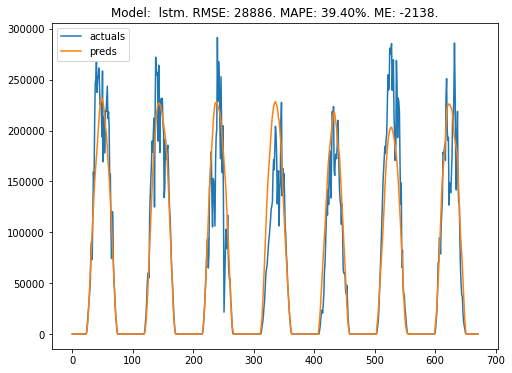

In [59]:
# visualize results

fig, ax = plt.subplots(figsize=(8, 6))
print_plot_results(res_lstm, ax=ax, mode='dev')

# 4. Comparison <a id='comp'></a>
[to the top](#top)

## 4.1 Model Comparison

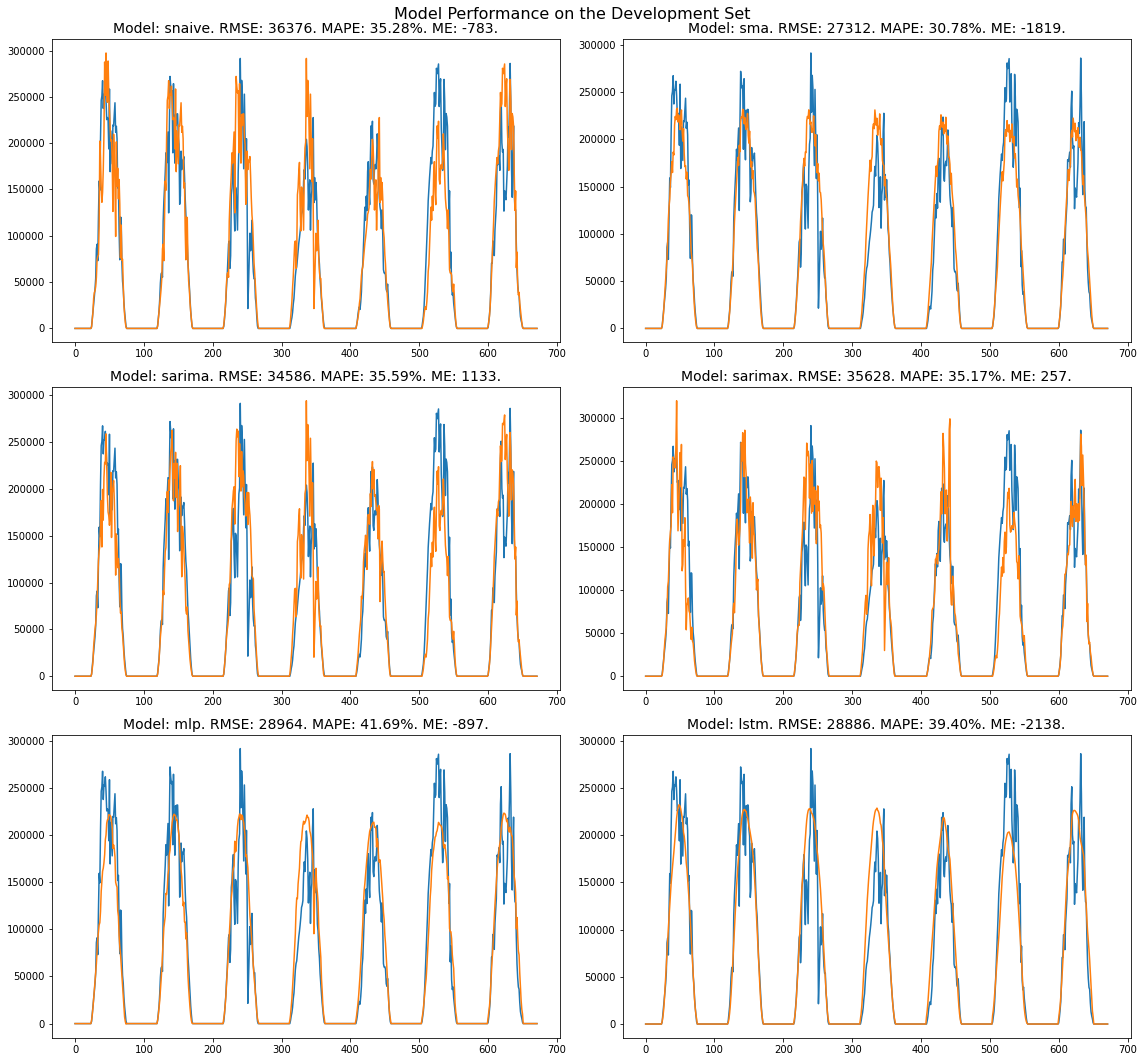

In [60]:
combined_results = load_obj(r'../Results', r'/combined_prediction_results')

n_plots = len(combined_results)
ncols = 2
nrows = int(np.ceil(n_plots/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*8, nrows*5))
tfs, stfs = 16, 14

for n, (model_name, model_res) in enumerate(combined_results.items()):
    
    ax = axes[n//ncols, n%ncols]
    ax.plot(model_res.y_dev, label='actuals')
    ax.plot(model_res.preds_dev, label='preds')
    ax.set_title('Model: {}. RMSE: {:.0f}. MAPE: {:.2f}%. ME: {:.0f}.'.format(model_name, *model_res.errors[:3]),
                fontsize=stfs)
    
fig.suptitle("Model Performance on the Development Set", fontsize=tfs)
fig.tight_layout()

## 4.2 Model Selection and Probabilistic Predictions

The SARIMAX models an the seasonal naive method produce very noisy predictions, which we would like to avoid. The remaining three models (sma, mlp, lstm) produce much smoother forecasts. The best among the three in terms of both RMSE and MAPE is the seasonal moving average, so we select it as our preferred forecasting model. Even if it was slightly worse, we would probably choose it as it is almost always desirable to sacrifice a tiny bit of performance in favor of model simplicity. <br>
Let's use our chosen model to predict the test set and the future. In reality, it is also always interesting to see how confident the model is about its predictions, so we'll create a confidece band around the point predictions assuming a normal distribution.

Text(0.5, 1.0, 'Prediction Errors (Training and Dev Set)')

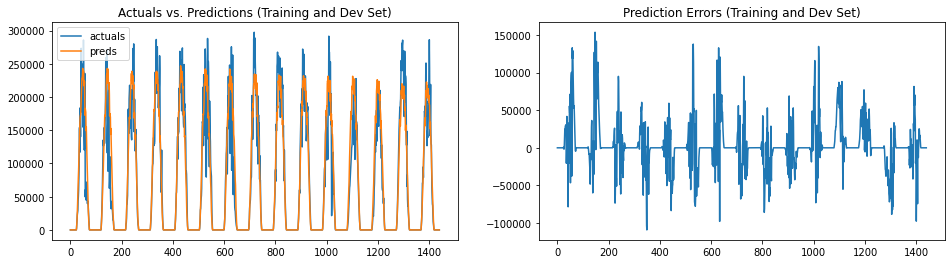

In [61]:
# errors on training and development set

agg_df = pd.read_csv(r'../Data Sets/agg_df.csv')

best_k = 15
preds = np.array([np.mean(agg_df['dc'].values[t-best_k*M:t:M]) for t in range(best_k*M, N_TRAIN+N_DEV)])
target_y = agg_df['dc'].values[best_k*M:N_TRAIN+N_DEV]

fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

ax = axes[0]
ax.plot(target_y, label='actuals')
ax.plot(preds, label='preds')
ax.legend()
ax.set_title('Actuals vs. Predictions (Training and Dev Set)')

errors = preds-target_y
ax = axes[1]
ax.plot(errors)
ax.set_title('Prediction Errors (Training and Dev Set)')

Text(0.5, 1.0, 'Standard Deviation of Errors Over One Day')

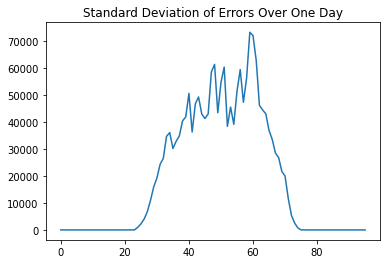

In [62]:
# error volatility

errors = preds-target_y
error_stds = [np.std(errors[t:len(errors):M]) for t in range(M)]
plt.plot(error_stds)
plt.title('Standard Deviation of Errors Over One Day')

Text(0.5, 1.0, 'Test Set and Future Predictions with 90% Confidence Band')

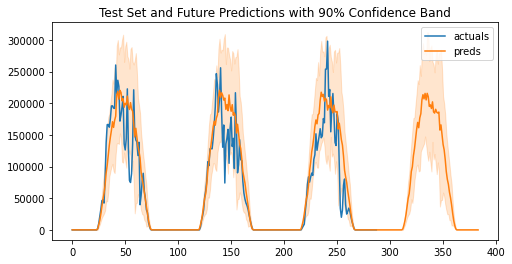

In [63]:
# probabilistic predictions for test set and one day in the future

gamma = .9 # confidence level
factor = scipy.stats.norm.ppf(gamma+(1-gamma)/2)

agg_df = pd.read_csv(r'../Data Sets/agg_df.csv')
preds = np.array([np.mean(agg_df['dc'].values[t-best_k*M:t:M]) for t in range(N_TRAIN+N_DEV, N_TRAIN+N_DEV+N_TEST+M)])
target_y = agg_df['dc'].values[N_TRAIN+N_DEV:]

fig, ax = plt.subplots(figsize=(8, 4))

repeated_stds = np.tile(error_stds, len(preds)//M)
x = range(len(preds))
ax.plot(target_y, label='actuals')
ax.plot(x, preds, label='preds')
ax.fill_between(x, preds-factor*repeated_stds, preds+factor*repeated_stds, color='C1', alpha=.2)
ax.legend()
ax.set_title('Test Set and Future Predictions with {:.0f}% Confidence Band'.format(gamma*100))

# 5. Conclusion<a id='conclusion'></a>
[to the top](#top)

## 5.1 Summary<a id='summary'></a>
[to the top](#top)

The research questions can be answered in the following way:
1. The most accurate predictions are produced by the (rather simplistic) seasonal moving average method. With a MAPE of 30% on the development set, however, we can not confidently say that we found a very accurate model.
2. On the given data set, we could not observe any benefit of applying more complex models. More precisely, recurrent neural nets did not ourperform the simpler feed-forward architecture, while both neural net types did not perform better than the (rather naive) seasonal moving average.
3. The following reasons contribute to the above observations:
    + With only 34 days worth of data and very few useful explanatory variables, the data set is not ideally suited for machine learning algorithms, and the rather bad performance of the neural nets is not surprising.
    + Essentially, the energy prediction problem boils down to predicting the weather (better: the solar irradiance) 24 hours in advance for a 15-minute interval, while all we are given is the time of day and the weather for the past for days. Unsurprisingly, this is a rather hopeless task.

## 5.2 Further Ideas<a id='ideas'></a>
[to the top](#top)

- To improve the predictions:
    + gather more data:
    + increase training time and optimize the hyperparameters of the neural networks
    + frame the problem differently, i.e., modify the target variable: predict daily dc power (instead of 15 minutes intervalls), or use a bottom up approach (predict inverters individually, then aggregate the forecasts)
- investigate the effect of changing the size of the training sets on the model performances (less interesting here, as the data set ist small already, but an interesting question in general as it allows to determine what data size is required for a ML model to achieve a decent performance)
- investigate the importance of specific features (presumably, the frequency features are quite important); see chapter 6
- try other, more suitable time series models: GARCH, ETS, Fourier Decomposition
- investigate if ensemble learning can help improve the predictions (e.g. combine Deep Learning and ARIMA); see also chapter 7

## 5.3 Regarding this Notebook and your Submissions <a id='comments'></a>
[to the top](#top)

- This notebook is not meant to be used as a template. Please develop your own ideas and create your own code! Nonetheless, there are some good methodological features in this notebook, which I would like to emphasize:
    + Use text and comments in abundance to explain your code. One of the main advantages of jupyter notebooks are the markdown cells, which you should use to give your submission a clear structure. You may also add images if applicable.
    + Do not dive blindly into a subject / data set, but define a purpose / research question and a clear structure of how to answer it before starting to work on your submission. (In our case: ARIMA vs. MLP vs. LSTM.) Discuss your findings at the end of the notebook.
    + Remember that quantity is not key. Tailor work to your research question. Instead of fitting every model available in scikit-learn, make reasonable choices and spend your time on data preprocessing and refinement + explanation of a few (maybe only two) models.
    + Keep the cell's output when submitting your notebook.
    + Turn off irrelevant warnings.
- In addition: Do not forget the other grading criteria (see introduction slides)

**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------** <br>
**------------------------------------------------------------------------------------------- End of Main Part ----------------------------------------------------------------------------------------------** <br>
**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# 6. Excursion: Feature Importance <a id='f_imp'></a>
[to the top](#top)

Had we chosen a hard-to-interpret ML model, e.g. a neural network, we might have wanted to proceed with a deeper analysis on how the model comes up with its predictions. There are many reasonable approaches to render an ML model more explainable, one of which is SHAP. SHAP can be used to both locally (for a specific feature vector) and globally (independent of a specific data sample) explain a model's decisions. In a nutshell, SHAP computes a feature's importance (or better: the contribution of a feature to a prediction) by analyzing how much the predictions change in response to a change of that feature. You can read more about interpretable Machine Learning (most notably Permutation Feature Importance, SHAP, and LIME) at https://christophm.github.io/interpretable-ml-book.html. You will also discuss this important topic in more detail in the Education sector.

In [64]:
# recover MLP data

agg_df = pd.read_csv(r'../Data Sets/agg_df.csv')
feature_names = agg_df.columns[1:]

MLP_scaler = StandardScaler()
MLP_scaler.fit(agg_df.iloc[:N_TRAIN, :])
MLP_data = MLP_scaler.transform(agg_df)
MLP_X, MLP_y = MLP_data[:, 1:], MLP_data[:, 0]
X_dev = MLP_X[N_TRAIN:N_TRAIN+96]
y_dev = MLP_y[N_TRAIN:N_TRAIN+96]

mlp = load_model(r'C:/Users/rbeier/Desktop/AIinIndustry23/Energy_Models/mlp')

**Permutation Feaure Importance:**

In [65]:
r = permutation_importance(mlp, X_dev, y_dev, n_repeats=30, scoring='neg_root_mean_squared_error')

Text(0.5, 1.0, 'Permutation Feature Importance')

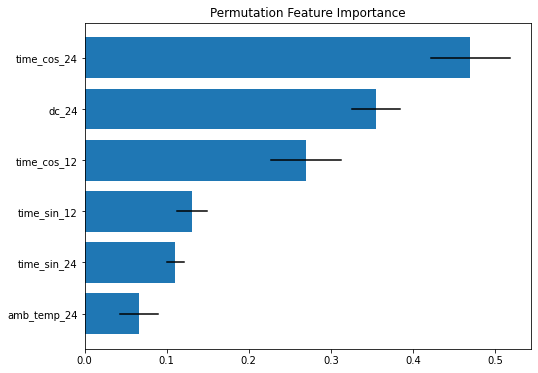

In [66]:
fig, ax = plt.subplots(figsize=(8, 6))
sorted_feature_names = []

for y, i in enumerate(r['importances_mean'].argsort()):
    ax.barh(y, r['importances_mean'][i], color='C0')
    ax.plot(np.linspace(r['importances_mean'][i]-r['importances_std'][i], r['importances_mean'][i]+r['importances_std'][i]),
            [y]*50, color='k')
    sorted_feature_names.append(feature_names[i])
    
ax.set_yticks(range(len(feature_names)), labels=sorted_feature_names)
ax.set_title('Permutation Feature Importance')

**SHAP:**

In [67]:
explainer = shap.KernelExplainer(mlp.predict, X_dev)
shap_values = explainer.shap_values(X_dev, nsamples=10)[0]

  0%|          | 0/96 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.471e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.869e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.313e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.642e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

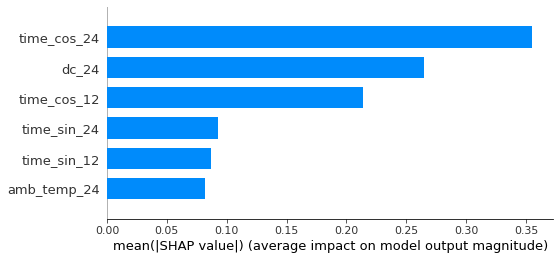

In [68]:
shap.summary_plot(shap_values, X_dev, feature_names=feature_names, plot_type='bar')

In [69]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[48,:], X_dev[48,:], feature_names=feature_names)

# 7. Excursion: Stacking in Scikit-Learn <a id='ensemble'></a>
[to the top](#top)

We also talked about how model ensembles can improve the individual models
An interesting question could be, whether this is the case for the given data (and why / why not), so let's compare the performance of a couple of simple, individual models with their stacked performance. This is readily implemented in scikit-learn:

In [70]:
# preprocesser 

preprocessor = Pipeline(steps=[('scaler', StandardScaler())])

data = pd.read_csv(r'../Data Sets/agg_df.csv')
X_train, X_dev, X_test = data.iloc[:N_TRAIN, 1:], data.iloc[N_TRAIN:N_TRAIN+N_DEV, 1:], data.iloc[N_TRAIN+N_DEV:, 1:]
y_train, y_dev, y_test = data.iloc[:N_TRAIN, 0], data.iloc[N_TRAIN:N_TRAIN+N_DEV, 0], data.iloc[N_TRAIN+N_DEV:, 0]

## 7.1 Ridge

Regression with L1 regularization: estimates sparse coefficients.

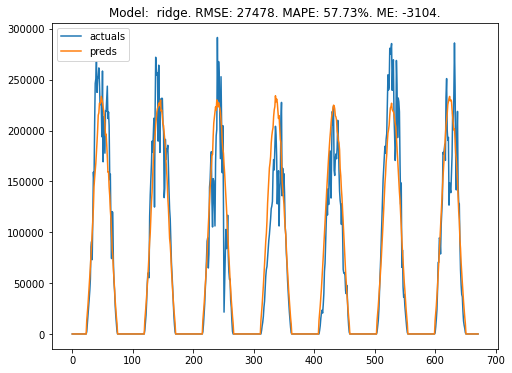

In [71]:
# grid search parameters
params_ridge = {'regressor__alpha':np.linspace(0.01, 0.05, 5)}

# pipeline
pipeline_ridge = pipeline(Ridge(), params_ridge, preprocessor, n_jobs=1, verbose=False)

# fit and evaluate pipeline
result = eval_pipeline(pipeline_ridge, X_train, X_dev, X_test, y_train, y_dev, y_test, 'ridge')

# print and plot results
fig, ax = plt.subplots(figsize=(8,6))
print_plot_results(result, ax=ax, mode='dev')

## 7.2 Linear SVR

Support vector regression

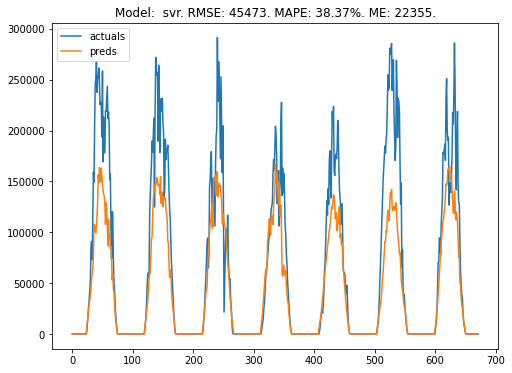

In [72]:
# grid search parameters
params_svr = {'regressor__C': np.linspace(.1, 50, 5)}

# pipeline
pipeline_svr = pipeline(LinearSVR(), params_svr, preprocessor, n_jobs=1, verbose=False)

# fit and evaluate pipeline
result = eval_pipeline(pipeline_svr, X_train, X_dev, X_test, y_train, y_dev, y_test, 'svr')

# print and plot results
fig, ax = plt.subplots(figsize=(8,6))
print_plot_results(result, ax=ax, mode='dev')

## 7.3 Stacking

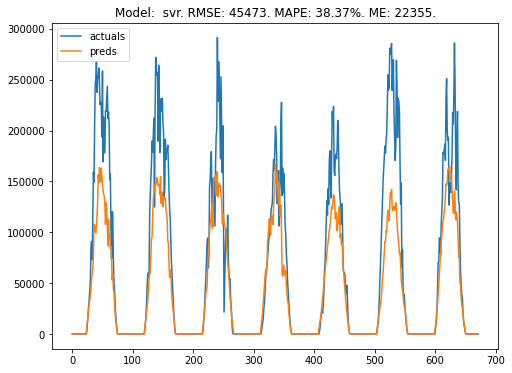

In [73]:
# stacking


estimators = [
    ('ridge', Ridge()),
    ('svr', LinearSVR(random_state=42)),
]

reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(random_state=42)
)

# grid search parameters
params_stacked = {'regressor__ridge__alpha': np.linspace(.01, .05, 5),
                  'regressor__svr__C': np.linspace(.1, 50, 5),
                  'regressor__final_estimator__n_estimators': range(10, 51, 10)}

# pipeline
pipeline_stacked = pipeline(reg, params_stacked, preprocessor, n_jobs=1, verbose=False)

# fit and evaluate pipeline
result_stacked = eval_pipeline(pipeline_stacked, X_train, X_dev, X_test, y_train, y_dev, y_test, 'stacked')

# print and plot results
fig, ax = plt.subplots(figsize=(8,6))
print_plot_results(result, ax=ax, mode='dev')